In [1]:
import sys
import os 
sys.path.append(os.path.dirname(os.getcwd()) + "/src/")
import warnings
import omegaconf
from matplotlib import pyplot as plt
%matplotlib inline
import torch
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
from dataloader.ssl_dataloader import get_dataset

warnings.filterwarnings("ignore")

from model.model import Model
from model.config import ModelConfig

ModuleNotFoundError: No module named 'dataloader'

## Boilerplate needed for notebooks

In [3]:
# ManifoldCLR TIN Path
ckpt_path = "../results/tin_vi_dict128_kl1e-5_proj_to10_trial2_05-22-2023_10-47-40/checkpoints/checkpoint_epoch999.pt"
ckpt_path = "../neuro_results/tin_manifoldclr_weights.pt"
cfg_path = "../results/tin_vi_dict128_kl1e-5_proj_to10_trial2_05-22-2023_10-47-40/.hydra/config.yaml"
cfg_path = "../neuro_results/tin_manifoldclr_cfg.yaml"

device_idx = [0]
# Set the default device
default_device = torch.device("cuda:0")
default_device = torch.device("cpu")
# Load config
cfg = omegaconf.OmegaConf.load(cfg_path)
cfg.model_cfg.backbone_cfg.load_backbone = None

# CUSTOM CONFIG FOR THIS RUN #

# Load model
default_model_cfg = ModelConfig()
model = Model.initialize_model(cfg.model_cfg, cfg.dataloader_cfg.dataset_cfg.dataset_name, device_idx)
state_dict = torch.load(ckpt_path, map_location=default_device)
model.load_state_dict(state_dict['model_state'], strict=False)
# Manually override directory for dataloaders
cfg.dataloader_cfg.dataset_cfg.dataset_dir = "../datasets/tiny-imagenet-200"
cfg.dataloader_cfg.train_batch_size = 500
# Load dataloaders
# TODO: get data
# dataset = get_dataset(cfg.dataloader_cfg)
# train_dataloader = dataset.eval_dataloader
# test_dataloader = dataset.val_dataloader

# Load transport operators
backbone = model.backbone.backbone_network
transop, coeff_enc = (None, None)
if model.contrastive_header.transop_header is not None:
    transop = model.contrastive_header.transop_header.transop
    coeff_enc = model.contrastive_header.transop_header.coefficient_encoder

Using cache found in /home/kyle/.cache/torch/hub/pytorch_vision_v0.10.0


In [4]:
from torch import nn
from torchvision import models
resnet = models.resnet18(pretrained=True).to(default_device)
resnet.fc = nn.Identity()

In [5]:
import brainscore
from tqdm import tqdm
sys.path.append(os.path.dirname(os.getcwd()) + "/neuro_simclr/")
from datasets import pose_dims, generate_brainscore_train_test_split

In [6]:

# def generate_brainscore_train_test_split(random_seed=42, split_percentage=0.8):
#     # Set numpy seed
#     np.random.seed(random_seed)
#     torch.manual_seed(random_seed)
#     # Generates a consistent train test split of the brainscore dataset
#     # along the presentation dimension
#     neural_data = brainscore.get_assembly(name="dicarlo.MajajHong2015.public")
#     neural_data = neural_data.squeeze("time_bin")
#     neural_data = neural_data.transpose("presentation", "neuroid")
#     # Randomly select 80% of the presentations to be the train set
#     train_indices = np.random.choice(
#         np.arange(len(neural_data)), size=int(len(neural_data) * split_percentage), replace=False
#     )
#     # Subtract train_indices to get test indices
#     test_indices = np.setdiff1d(np.arange(len(neural_data)), train_indices)
#     # Set the data
#     train_data = neural_data[train_indices]
#     test_data = neural_data[test_indices]

#     return train_data, test_data

def get_pixel_dataset(flatten_images=True, random_seed=0, output_resolution=32):
    """
    Returns images and labelsfrom the dicarlo dataset
    corresponding to the splits outputted by
    generate_brainscore_train_test_split
    """
    neuroid_train_data, neuroid_test_data = generate_brainscore_train_test_split(random_seed=random_seed, return_numpy=False)
    # Get the train and test data
    # NOTE: Always average over trials because there is just one image per stimulus (image is the stimulus)
    train_stimulus_set = neuroid_train_data.attrs["stimulus_set"]
    train_data = neuroid_train_data.multi_groupby(["category_name", "object_name", "stimulus_id"]).mean(
        dim="presentation"
    )
    test_stimulus_set = neuroid_test_data.attrs["stimulus_set"]
    test_data = neuroid_test_data.multi_groupby(["category_name", "object_name", "stimulus_id"]).mean(
        dim="presentation"
    )

    # Get the images
    # Helper function for transforming stimulus
    def transform_stimulus(stimulus_path):
        img = Image.open(stimulus_path)
        img = transforms.Resize((output_resolution, output_resolution))(img)
        img = transforms.ToTensor()(img)
        if flatten_images:
            img = img.flatten()
        return img

    # NOTE this may be very slow and we may want to then cache it.
    # Load the train images
    train_stimulus_ids = train_data.stimulus_id.to_numpy()
    pixel_train = torch.stack(
        [transform_stimulus(train_stimulus_set.get_stimulus(stimulus_id)) for stimulus_id in train_stimulus_ids]
    )
    # Load test images
    test_stimulus_ids = test_data.stimulus_id.to_numpy()
    pixel_test = torch.stack(
        [transform_stimulus(test_stimulus_set.get_stimulus(stimulus_id)) for stimulus_id in test_stimulus_ids]
    )
    # Get the category labels
    train_category = train_data.category_name.to_numpy()
    _, label_train = np.unique(train_category, return_inverse=True)

    test_category = test_data.category_name.to_numpy()
    _, label_test = np.unique(test_category, return_inverse=True)

    label_train = torch.tensor(label_train).long()
    label_test = torch.tensor(label_test).long()
    # Load object ids
    train_object = train_data.object_name.to_numpy()
    _, object_id_train = np.unique(train_object, return_inverse=True)
    object_id_train = torch.tensor(object_id_train).long()

    test_object = test_data.object_name.to_numpy()
    _, object_id_test = np.unique(test_object, return_inverse=True)
    object_id_test = torch.tensor(object_id_test).long()

    # V4, IT
    v4_train = torch.tensor(train_data.sel(region='V4').to_numpy())
    v4_test = torch.tensor(test_data.sel(region='V4').to_numpy())
    it_train = torch.tensor(train_data.sel(region='IT').to_numpy())
    it_test = torch.tensor(test_data.sel(region='IT').to_numpy())


    return (pixel_train, label_train, object_id_train, v4_train, it_train), (pixel_test, label_test, object_id_test, v4_test, it_test)

In [7]:
# (pixel_train, label_train, object_id_train), (pixel_test, label_test, object_id_test) = get_pixel_dataset(flatten_images=False, random_seed=0, output_resolution=64)
# (pixel_train, label_train, object_id_train), (pixel_test, label_test, object_id_test) = get_pixel_dataset(flatten_images=False, random_seed=0, output_resolution=224)
(pixel_train, label_train, object_id_train, v4_train, it_train), (pixel_test, label_test, object_id_test, v4_test, it_test) = get_pixel_dataset(flatten_images=False, random_seed=0, output_resolution=224)

Loading catalog from entrypoints
Loading lookup from /home/kyle/mambaforge/envs/manifold-contrastive/lib/python3.9/site-packages/brainscore/lookup.csv


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2560/2560 [00:09<00:00, 276.11it/s]


In [8]:
sys.path.append(os.path.dirname(os.getcwd()) + "/neuro_simclr/")
from evaluation import get_model_output_on_cpu
pixel_train = pixel_train.to(default_device)
resnet.eval()
z = get_model_output_on_cpu(pixel_train, resnet, default_device)
print(z.shape)

torch.Size([2560, 512])


In [9]:
z_test = get_model_output_on_cpu(pixel_test, resnet, default_device)
z_test.shape

torch.Size([640, 512])

In [10]:
from evaluation import eval_IT_pred_best_layer, evaluate_IT_explained_variance, _eval_linear_regr_median_r, _eval_linear_regr_median_r2
def eval_best_layer(eval_fn, backbone, contrastive_head, train_v4, train_Y, test_v4, test_Y, args):
    """
    Returns median r^2 value across IT sites for the best layer of the backbone
    or contrastive head.
    """
    backbone.eval()
    if contrastive_head is not None:
        raise NotImplementedError()
        contrastive_head.eval()
        ct_layers_names = [(contrastive_head, 'ct head')]
    else:
        ct_layers_names = []

    z_train, z_test = train_v4, test_v4
    r2s = []
    for name, layer in backbone.named_children():
        z_train = get_model_output_on_cpu(z_train, layer, args.device)
        z_test = get_model_output_on_cpu(z_test, layer, args.device)
        r2s.append(eval_fn(z_train, train_Y, z_test, test_Y))
        print(f'{name}: {r2s[-1]}')

    return np.max(r2s)

class Args:
    def __init__(self):
        self.device = default_device
args = Args()
# eval_IT_pred_best_layer(resnet, None, v4_train, it_train, v4_test, it_test)
# print(evaluate_IT_explained_variance(z, it_train, z_test, it_test, args))
# _eval_linear_regr_median_r(z, it_train, z_test, it_test)
print('R^2\n===')
r2 = eval_best_layer(_eval_linear_regr_median_r2, resnet, None, pixel_train, it_train, pixel_test, it_test, args)
print('\nPearson R\n=========')
r = eval_best_layer(_eval_linear_regr_median_r, resnet, None, pixel_train, it_train, pixel_test, it_test, args)

R^2
===


: 

: 

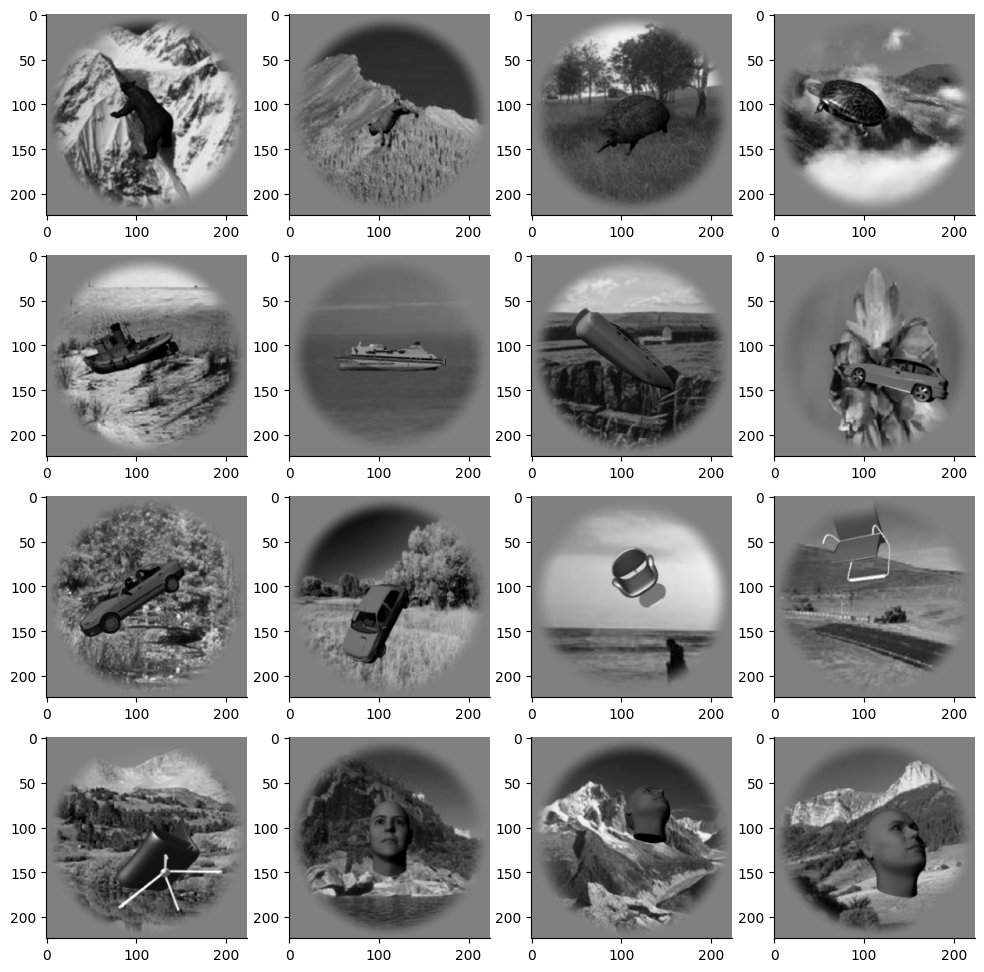

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
for i in range(16):
    row = i // 4
    column = i % 4
    ax[row, column].imshow(pixel_train[i*100].detach().cpu().permute(1,2,0))

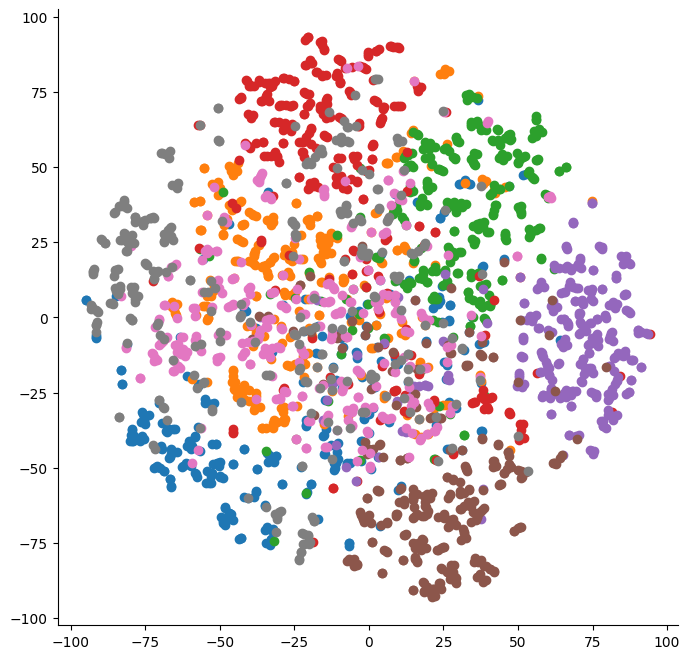

In [ ]:
from sklearn.manifold import TSNE

fig = plt.figure(figsize=(8, 8))
feat_embed = TSNE(n_components=2, init="random", perplexity=3).fit_transform(
    z.detach().cpu().numpy()
)
for label in np.unique(label_train):
    label_idx = label_train == label
    plt.scatter(*feat_embed[label_idx].T)